In [412]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
#from sklearn.svm import LinearSVC
from sklearn import svm 
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
pd.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv('diabetes.csv')
df

,Diabetes,HighBP,HighChol,BMI,Smoker,Stroke,Myocardial,PhysActivity,Fruit,Vegetables,HeavyDrinker,HasHealthcare,NotAbleToAffordDoctor,GeneralHealth,MentalHealth,PhysicalHealth,HardToClimbStairs,BiologicalSex,AgeBracket,EducationBracket,IncomeBracket,Zodiac
0,0,1,1,40,1,0,0,0,0,1,0,1,0,5,18,15,1,1,9,4,3,10
1,0,0,0,25,1,0,0,1,0,0,0,0,1,3,0,0,0,1,7,6,1,11
2,0,1,1,28,0,0,0,0,1,0,0,1,1,5,30,30,1,1,9,4,8,2
3,0,1,0,27,0,0,0,1,1,1,0,1,0,2,0,0,0,1,11,3,6,11
4,0,1,1,24,0,0,0,1,1,1,0,1,0,2,3,0,0,1,11,5,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0,1,1,45,0,0,0,0,1,1,0,1,0,3,0,5,0,2,5,6,7,11
253676,1,1,1,18,0,0,0,0,0,0,0,1,0,4,0,0,1,1,11,2,4,6
253677,0,0,0,28,0,0,0,1,1,0,0,1,0,1,0,0,0,1,2,5,2,5
253678,0,1,0,23,0,0,0,0,1,1,0,1,0,3,0,0,0,2,7,5,1,6


In [26]:
modelPerformances = pd.DataFrame(columns = ['AUC'])

# Baisc EDA

In [7]:
# Check for nans
for ii in df.columns:
    print("%s: %d" % (ii,df[ii].isna().sum()))
    
# good news, no nans

Diabetes: 0
HighBP: 0
HighChol: 0
BMI: 0
Smoker: 0
Stroke: 0
Myocardial: 0
PhysActivity: 0
Fruit: 0
Vegetables: 0
HeavyDrinker: 0
HasHealthcare: 0
NotAbleToAffordDoctor: 0
GeneralHealth: 0
MentalHealth: 0
PhysicalHealth: 0
HardToClimbStairs: 0
BiologicalSex: 0
AgeBracket: 0
EducationBracket: 0
IncomeBracket: 0
Zodiac: 0


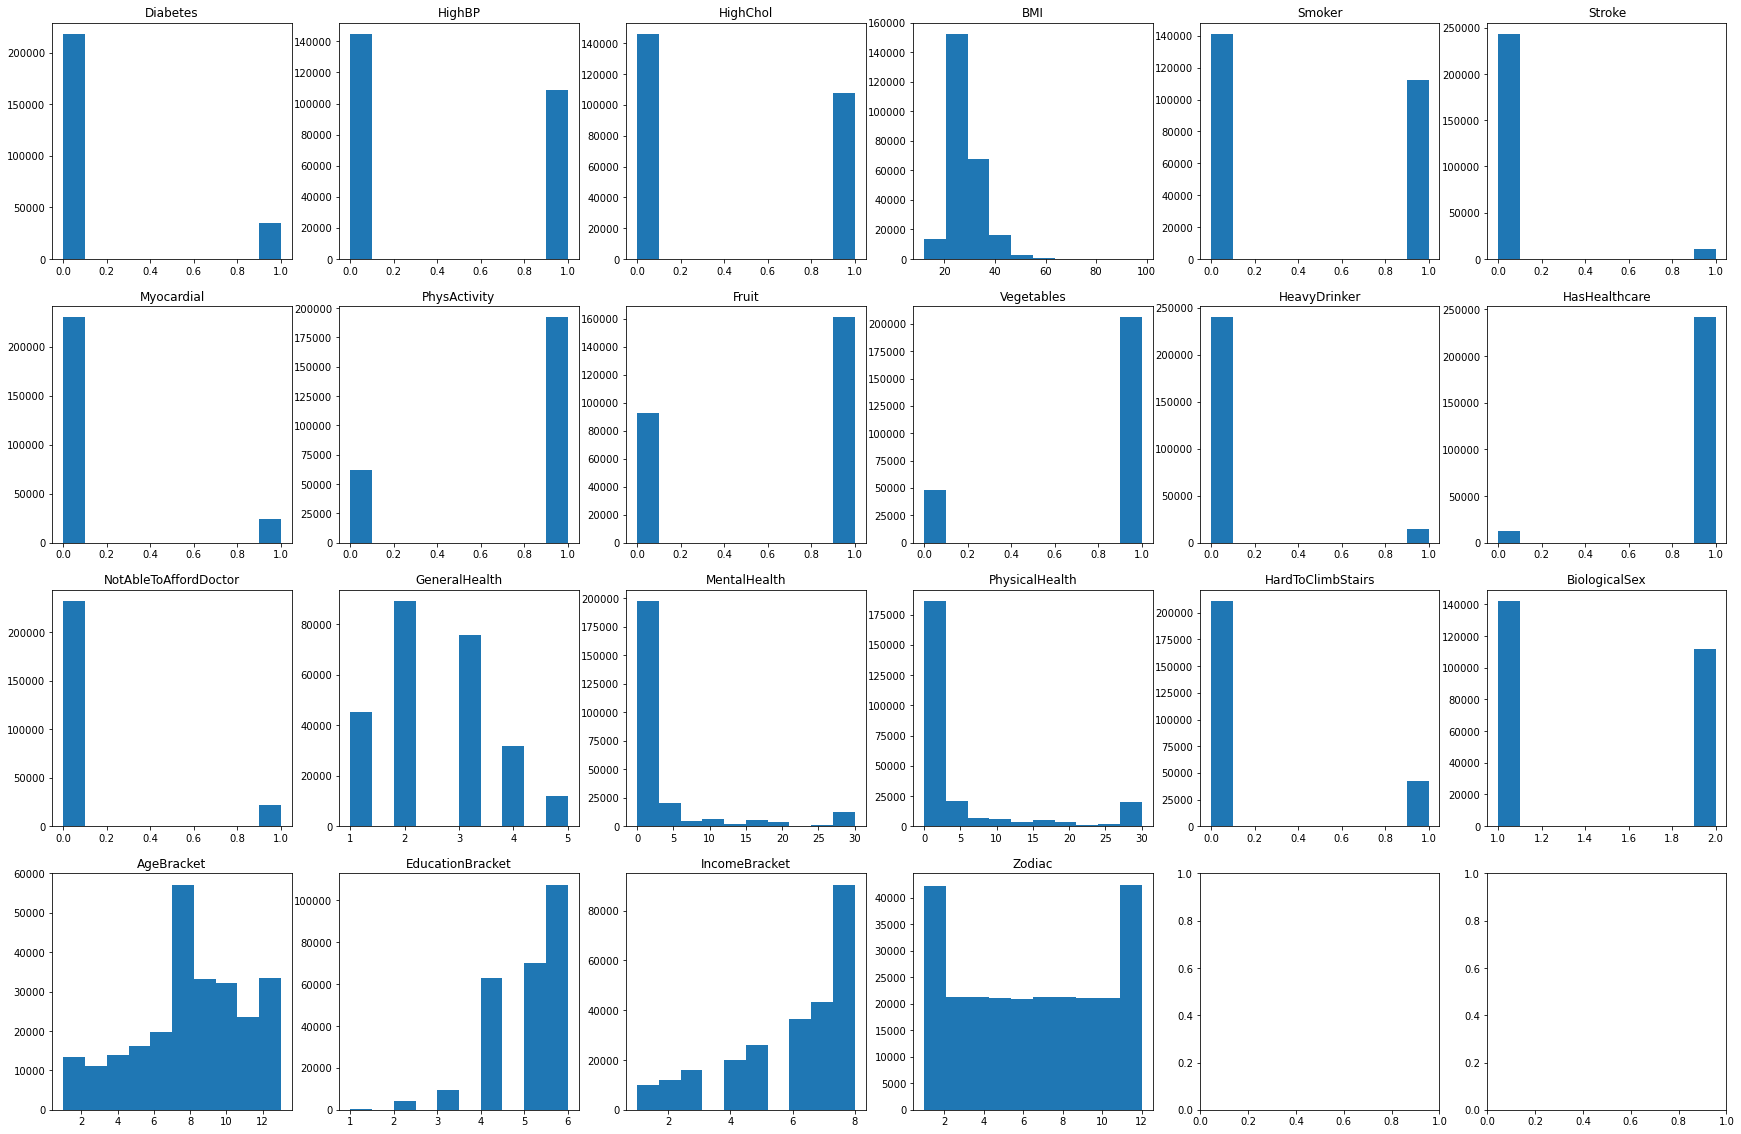

In [8]:
# See distributions
fig, axis = plt.subplots(4,6, figsize = (30,20))
z = 0
col = df.columns
for ii in range(4):
    for jj in range(6):
        try:
            axis[ii,jj].hist(df[col[z]])
            axis[ii,jj].set_title(col[z])
            z+= 1
        except:
            print()
            

# Build a logistic regression model. Doing so: What is the best predictor of diabetes and what is the AUC of this model?

In [20]:
X = df.drop('Diabetes', axis = 1)
y = df.Diabetes

In [16]:
# See base performabce
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2)
logi = LogisticRegression(dual = False, max_iter = 800)
logi.fit(XTrain, yTrain)
logiAuc = roc_auc_score(yTest, logi.predict_proba(XTest)[:,1])

logiAuc


0.8173797307864799

In [421]:
# 5 fold cv
logiAuc = cross_val_score(logi, X, y, scoring = 'roc_auc', n_jobs = -1, cv = StratifiedKFold(5, shuffle = True))
print(logiAuc.mean())
logiAuc

0.8205849350307025


array([0.8201624 , 0.82522474, 0.82044089, 0.81872199, 0.81837465])

In [28]:
modelPerformances.loc['LogisticRegression'] = logiAuc.mean()

In [ ]:
def getBetas(features, betas):
    return pd.DataFrame(data = betas, index = features, columns = ['Beta'])

# Shuffles each features and record the AUC of the model trained on the new data
def findBestPredictor(model, X, y):
    drop = pd.DataFrame(index = X.columns, columns = ['AUC'])
    drop.index.name = 'Shuffled Predictor'
    for ii in X.columns:
        temp = X.copy()
        temp[ii] = temp[ii].sample(frac = 1).reset_index(drop = True)
        drop.loc[ii] = cross_val_score(model, temp, y, scoring = 'roc_auc', cv = 5, n_jobs = -1).mean()
        
    return drop.sort_values('AUC')


In [25]:
findBestPredictor(logi, X, y)
# GeneralHealth is the most important

,AUC
Shuffled Predictor,
GeneralHealth,0.805225
BMI,0.805695
HighBP,0.812682
AgeBracket,0.812703
HighChol,0.814982
HeavyDrinker,0.819049
BiologicalSex,0.819431
Myocardial,0.819762
IncomeBracket,0.819794


In [356]:
getBetas(X.columns, logi.coef_[0]).sort_values('Beta', ascending = False)
# We see that GeneralHealth does not have the highest beta magnitude. This is because of the scale differences.


,Beta
Shuffled Predictor,
HighBP,0.783979
HighChol,0.588614
GeneralHealth,0.543180
BiologicalSex,0.242053
Myocardial,0.223813
HasHealthcare,0.154436
AgeBracket,0.125013
HardToClimbStairs,0.122653
Stroke,0.122081


# Build a SVM. Doing so: What is the best predictor of diabetes and what is the AUC of this model?
 

In [418]:
# Base model performance
SVM = svm.LinearSVC(C = 1, dual = False)
svmAuc = cross_val_score(SVM, X, y, scoring = 'roc_auc', n_jobs = -1, cv = StratifiedKFold(5, shuffle = True))
print(svmAuc.mean())
svmAuc

0.8209847527677956


array([0.81970382, 0.82105351, 0.82316491, 0.82029717, 0.82070436])

In [419]:
# Tune C
C = np.logspace(-2, 2, 10)
temp = np.empty(len(C))*np.nan
for ii in tqdm(range(len(C))):
    SVM = svm.LinearSVC(C = C[ii], dual = False)
    temp[ii] = cross_val_score(SVM, X, y, scoring = 'roc_auc', n_jobs = -1).mean()


100%|██████████| 10/10 [00:21<00:00,  2.16s/it]


35.93813663804626


array([0.82063657, 0.82078113, 0.82082139, 0.82083715, 0.82083894,
       0.82084094, 0.82084085, 0.82084315, 0.82084355, 0.82083321])

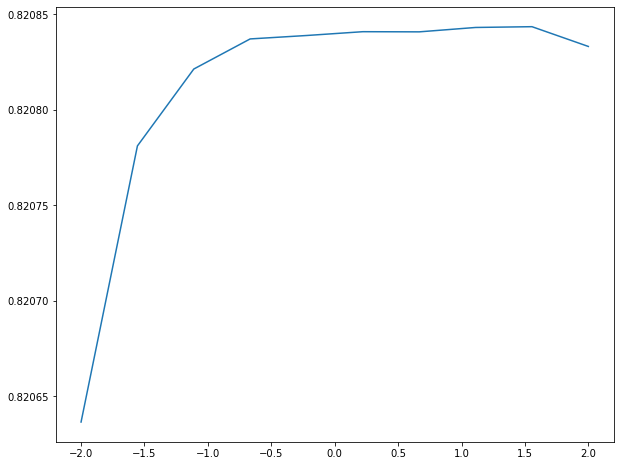

In [420]:
plt.figure(figsize=(10,8))
plt.plot(np.log10(C), temp)
print(C[np.argmax(temp)])
temp
# at C = 1, the AUC basically stops increasing

In [372]:
SVM = svm.LinearSVC(dual = False, C = 1)
svmAuc = cross_val_score(SVM, X, y, scoring = 'roc_auc', n_jobs = -1)
modelPerformances.loc['SVM'] = svmAuc.mean()
print(svmAuc.mean())
svmAuc

0.8208360471921349


array([0.82083843, 0.81215362, 0.82463702, 0.82177026, 0.82478091])

In [83]:
findBestPredictor(SVM, X, y)
# again, general health is the best predictor

,AUC
Shuffled Predictor,
GeneralHealth,0.805101
BMI,0.805454
HighBP,0.812292
AgeBracket,0.812928
HighChol,0.81474
HeavyDrinker,0.818589
BiologicalSex,0.81901
IncomeBracket,0.819325
Myocardial,0.819342


# Use a single, individual decision tree. Doing so: What is the best predictor of diabetes and what is the AUC of this model?

In [422]:
tree = DecisionTreeClassifier()
treeAuc = cross_val_score(tree, X, y, cv = StratifiedKFold(5, shuffle = True), scoring = 'roc_auc').mean()
print(treeAuc)

0.5962720070169476


In [415]:
tree = DecisionTreeClassifier(min_samples_leaf = 0.002, min_samples_split = 2)#, criterion='entropy')
treeAuc = cross_val_score(tree, X, y, cv = StratifiedKFold(5, shuffle = True), scoring = 'roc_auc').mean()
modelPerformances.loc['DecisionTree'] = treeAuc
print(treeAuc)

0.818140677448816


In [130]:
minLeaf = 1/np.logspace(0.302,3, 6, base = 10)
minSplit = [2,3,4,5]
treeGrid = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid = {'min_samples_leaf': minLeaf, 'min_samples_split': minSplit}, scoring = 'roc_auc', verbose = 3, n_jobs = -1).fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [375]:
treeGrid.best_params_

{'min_samples_leaf': 0.0034641764103524896, 'min_samples_split': 2}

In [379]:
tree = DecisionTreeClassifier(min_samples_leaf = treeGrid.best_params_['min_samples_leaf'], min_samples_split = 2)
treeAuc = cross_val_score(tree, X, y, cv = 5, scoring = 'roc_auc').mean()
print(treeAuc)
#This is not as good as the one I tried.

0.8171989944189683


In [137]:
treeBestPredictor = findBestPredictor(tree, X, y)
treeBestPredictor.sort_values('AUC')
# Again, from my method, GeneralHealth is the most important.
# What does the tree's feature_importance say?


,AUC
Shuffled Predictor,
GeneralHealth,0.799885
BMI,0.805279
AgeBracket,0.809176
HighBP,0.810807
HighChol,0.81357
BiologicalSex,0.817173
IncomeBracket,0.817214
EducationBracket,0.817857
HardToClimbStairs,0.817859


In [141]:
tree.fit(XTrain, yTrain)
getBetas(X.columns, tree.feature_importances_).sort_values('Beta', ascending = False)
# feature_importance disagrees. HighBP has the highest feature_iomportance score.

,Beta
Shuffled Predictor,
HighBP,0.371831
GeneralHealth,0.299684
BMI,0.157491
AgeBracket,0.073929
HighChol,0.061884
Myocardial,0.009005
IncomeBracket,0.006349
BiologicalSex,0.005803
HardToClimbStairs,0.004614


# Build a random forest model. Doing so: What is the best predictor of diabetes and what is the AUC of this model?

In [424]:
cross_val_score(RandomForestClassifier(), X, y, scoring = 'roc_auc', n_jobs = -1, cv = StratifiedKFold(5, shuffle = True)).mean()

0.805841421380258

In [145]:
rf = RandomForestClassifier(n_estimators = 100, max_samples=0.1, max_features=0.2, bootstrap = True, criterion='gini', n_jobs = -1)
rfAuc = cross_val_score(rf, X, y, scoring = 'roc_auc', n_jobs = -1, verbose = 2)
print(rfAuc.mean())
rfAuc



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


0.8164662087693962


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


array([0.81489411, 0.81160826, 0.81981082, 0.8176221 , 0.81839576])

In [345]:

rf = RandomForestClassifier(bootstrap = True, n_jobs = 7)
params = {'n_estimators': [500, 1000, 1500, 2000 ],'max_samples': [0.1,0.2,0.3,0.4], 'max_features': [0.1,0.2,0.3,0.4]}
search = GridSearchCV(estimator = rf, param_grid = params, scoring = 'roc_auc', verbose = 3)
search.fit(X, y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END max_features=0.1, max_samples=0.1, n_estimators=500;, score=0.821 total time=   5.0s
[CV 2/5] END max_features=0.1, max_samples=0.1, n_estimators=500;, score=0.816 total time=   3.4s
[CV 3/5] END max_features=0.1, max_samples=0.1, n_estimators=500;, score=0.826 total time=   3.1s
[CV 4/5] END max_features=0.1, max_samples=0.1, n_estimators=500;, score=0.823 total time=   3.4s
[CV 5/5] END max_features=0.1, max_samples=0.1, n_estimators=500;, score=0.824 total time=   3.3s
[CV 1/5] END max_features=0.1, max_samples=0.1, n_estimators=1000;, score=0.822 total time=   5.7s
[CV 2/5] END max_features=0.1, max_samples=0.1, n_estimators=1000;, score=0.817 total time=   5.5s
[CV 3/5] END max_features=0.1, max_samples=0.1, n_estimators=1000;, score=0.826 total time=   5.9s
[CV 4/5] END max_features=0.1, max_samples=0.1, n_estimators=1000;, score=0.823 total time=   5.7s
[CV 5/5] END max_features=0.1, max_samples=0.1, n_es

GridSearchCV(estimator=RandomForestClassifier(n_jobs=7),
             param_grid={'max_features': [0.1, 0.2, 0.3, 0.4],
                         'max_samples': [0.1, 0.2, 0.3, 0.4],
                         'n_estimators': [500, 1000, 1500, 2000]},
             scoring='roc_auc', verbose=3)

In [427]:
#print(search.best_params_)
rf = RandomForestClassifier(n_estimators = 2000, max_features = 0.2, max_samples = 0.1, bootstrap = True, n_jobs = -1)
rfAuc = cross_val_score(rf, X, y, scoring = 'roc_auc', n_jobs = -1, cv = StratifiedKFold(5, shuffle = True))
print(rfAuc.mean())
#0.8235
modelPerformances.loc['RandomForest'] = rfAuc.mean()

0.8237453970790055


In [152]:
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2)
rf.fit(XTrain, yTrain)
getBetas(X.columns, rf.feature_importances_).sort_values('Beta',ascending = False)
# Feature importance attribute tells use that BMI is the most important
# But what is Zodiac doing so high up here??

,Beta
Shuffled Predictor,
BMI,0.152861
Zodiac,0.115649
AgeBracket,0.103962
IncomeBracket,0.082377
GeneralHealth,0.072679
PhysicalHealth,0.069314
EducationBracket,0.058740
MentalHealth,0.052992
HighBP,0.043072


[CV] END min_samples_leaf=0.49888448746001224, min_samples_split=3; total time=   0.1s
[CV] END min_samples_leaf=0.49888448746001224, min_samples_split=5; total time=   0.1s
[CV] END min_samples_leaf=0.14401243711755707, min_samples_split=3; total time=   0.2s
[CV] END min_samples_leaf=0.14401243711755707, min_samples_split=4; total time=   0.2s
[CV] END min_samples_leaf=0.04157191206752182, min_samples_split=3; total time=   0.3s
[CV] END min_samples_leaf=0.04157191206752182, min_samples_split=4; total time=   0.3s
[CV] END min_samples_leaf=0.012000518202042657, min_samples_split=3; total time=   0.4s
[CV] END min_samples_leaf=0.012000518202042657, min_samples_split=4; total time=   0.4s
[CV] END min_samples_leaf=0.0034641764103524896, min_samples_split=2; total time=   0.5s
[CV] END min_samples_leaf=0.0034641764103524896, min_samples_split=4; total time=   0.6s
[CV] END ........min_samples_leaf=0.001, min_samples_split=3; total time=   0.6s
[CV] END ........min_samples_leaf=0.001, mi

In [160]:
rf = RandomForestClassifier(n_estimators = 2000, max_features = 0.2, max_samples = 0.1)
findBestPredictor(rf, X, y)
# Using my own predefined method, BMI is the most important feature. General health comes in second but very close.

,AUC
Shuffled Predictor,
BMI,0.807536
GeneralHealth,0.808048
AgeBracket,0.813623
HighBP,0.816691
HighChol,0.818317
BiologicalSex,0.822065
Myocardial,0.822353
HeavyDrinker,0.822456
IncomeBracket,0.822766


# Build a model using adaBoost. Doing so: What is the best predictor of diabetes and what is the AUC of this model?

In [428]:
from sklearn.ensemble import AdaBoostClassifier
# Base performance
adb = AdaBoostClassifier()
adbAuc = cross_val_score(adb, X, y, scoring = 'roc_auc', n_jobs = -1, cv = StratifiedKFold(5, shuffle = True))
print(adbAuc.mean())
adbAuc

0.8250063795233


array([0.8253653 , 0.82652879, 0.82338975, 0.82471037, 0.82503769])

In [183]:
# perhaps we can do better
# What's the effect of n_estimators?
estimators = [50, 100, 200, 500, 1000]
aucs = np.empty(len(estimators))*np.nan
for ii in tqdm(range(len(estimators))):
    adb = AdaBoostClassifier(n_estimators = estimators[ii])
    aucs[ii] = cross_val_score(adb, X, y, scoring = 'roc_auc', n_jobs = -1).mean()
    

100%|██████████| 5/5 [02:35<00:00, 31.01s/it]


500


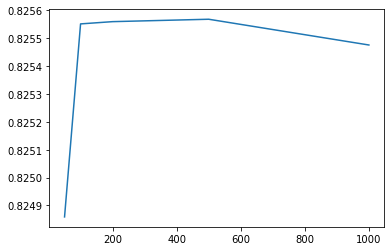

In [185]:
plt.plot(estimators, aucs)
print(estimators[np.argmax(aucs)])

In [192]:
# Now let's explore learning rate
lr = np.logspace(-10, -1, 10)
aucs = np.empty(len(lr))*np.nan
for ii in tqdm(range(len(lr))):
    adb = AdaBoostClassifier(n_estimators = 100, learning_rate = lr[ii])
    aucs[ii] = cross_val_score(adb, X, y, scoring = 'roc_auc', n_jobs = -1).mean()

100%|██████████| 10/10 [01:27<00:00,  8.76s/it]


0.1


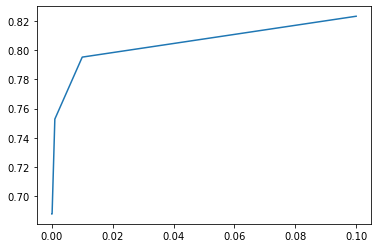

In [193]:
plt.plot(lr, aucs)
print(lr[np.argmax(aucs)])
# it seems like we need a higher learning rate

In [199]:
lr = np.logspace(-1,0.5, 10)
aucs = np.empty(len(lr))*np.nan
for ii in tqdm(range(len(lr))):
    adb = AdaBoostClassifier(n_estimators = 100, learning_rate = lr[ii])
    aucs[ii] = cross_val_score(adb, X, y, scoring = 'roc_auc', n_jobs = -1).mean()

100%|██████████| 10/10 [01:19<00:00,  7.95s/it]


1.0


array([0.82303308, 0.82465693, 0.82514253, 0.82535094, 0.82528825,
       0.82546853, 0.82555112, 0.82536169, 0.40837603, 0.38569912])

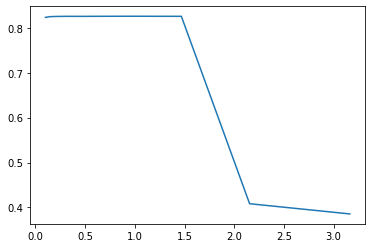

In [200]:
plt.plot(lr, aucs)
print(lr[np.argmax(aucs)])
aucs


In [207]:
# how about max_depth
depth = [1,2,3,4,5,6]
aucs = np.empty(len(depth))*np.nan
for ii in tqdm(range(len(depth))):
    adb = AdaBoostClassifier(DecisionTreeClassifier(max_depth = depth[ii]), n_estimators = 100, learning_rate = 1)
    aucs[ii] = cross_val_score(adb, X, y, scoring = 'roc_auc', n_jobs = -1).mean()
 

100%|██████████| 6/6 [02:08<00:00, 21.37s/it]


2


array([0.82555112, 0.82696843, 0.82404996, 0.81576489, 0.80386295,
       0.78563387])

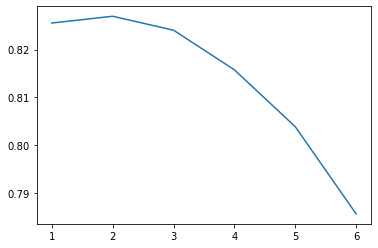

In [208]:
   
plt.plot(depth, aucs[:len(depth)])
print(depth[np.argmax(aucs)])
aucs

In [220]:
adb = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2), n_estimators = 500, learning_rate = 0.01)
adbAuc = cross_val_score(adb, X, y, scoring = 'roc_auc', n_jobs = -1).mean()

In [223]:
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2)
adb = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
params = {'base_estimator__max_depth':[1,2,3,4],
              'n_estimators':[100,500,1000],
              'learning_rate':[0.001, 0.01,0.1, 1]}
search = GridSearchCV(adb, params, scoring = 'roc_auc', verbose = 3, n_jobs = -1)
search.fit(XTrain, yTrain)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
             n_jobs=-1,
             param_grid={'base_estimator__max_depth': [1, 2, 3, 4],
                         'learning_rate': [0.001, 0.01, 0.1, 1],
                         'n_estimators': [100, 500, 1000]},
             scoring='roc_auc', verbose=3)

In [226]:
bestAdbParam = search.best_params_
bestScore = search.best_score_
print(bestAdbParam)
bestScore

{'base_estimator__max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 1000}


0.8282548811168425

[CV 1/5] END base_estimator__max_depth=1, learning_rate=0.001, n_estimators=500;, score=0.767 total time= 1.0min
[CV 5/5] END base_estimator__max_depth=1, learning_rate=0.01, n_estimators=500;, score=0.816 total time=  44.4s
[CV 5/5] END base_estimator__max_depth=1, learning_rate=0.1, n_estimators=100;, score=0.822 total time=   8.8s
[CV 5/5] END base_estimator__max_depth=1, learning_rate=0.1, n_estimators=500;, score=0.825 total time=  43.4s
[CV 5/5] END base_estimator__max_depth=1, learning_rate=0.1, n_estimators=1000;, score=0.825 total time= 1.4min
[CV 5/5] END base_estimator__max_depth=2, learning_rate=0.001, n_estimators=100;, score=0.762 total time=  13.4s
[CV 5/5] END base_estimator__max_depth=2, learning_rate=0.001, n_estimators=500;, score=0.793 total time= 1.1min
[CV 4/5] END base_estimator__max_depth=2, learning_rate=0.01, n_estimators=100;, score=0.805 total time=  13.6s
[CV 4/5] END base_estimator__max_depth=2, learning_rate=0.01, n_estimators=500;, score=0.822 total time

In [229]:
pd.DataFrame(search.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__max_depth,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
29,175.717756,0.257058,3.936878,0.048216,3,0.01,1000,"{'base_estimator__max_depth': 3, 'learning_rat...",0.831164,0.827447,0.828545,0.825413,0.828705,0.828255,0.001870,1
41,224.786983,0.397247,4.216187,0.043609,4,0.01,1000,"{'base_estimator__max_depth': 4, 'learning_rat...",0.830979,0.827520,0.828607,0.825029,0.828695,0.828166,0.001931,2
30,17.604481,0.120045,0.418329,0.012519,3,0.1,100,"{'base_estimator__max_depth': 3, 'learning_rat...",0.830958,0.827358,0.828500,0.825456,0.828380,0.828130,0.001786,3
40,116.504774,0.255788,2.234221,0.066641,4,0.01,500,"{'base_estimator__max_depth': 4, 'learning_rat...",0.830483,0.827048,0.828432,0.825514,0.828372,0.827970,0.001647,4
19,63.145144,0.254008,1.794296,0.028209,2,0.1,500,"{'base_estimator__max_depth': 2, 'learning_rat...",0.831110,0.827418,0.828040,0.824857,0.828183,0.827922,0.001994,5
20,126.650261,0.388234,3.612088,0.027647,2,0.1,1000,"{'base_estimator__max_depth': 2, 'learning_rat...",0.831308,0.827526,0.828069,0.824428,0.828122,0.827891,0.002186,6
42,22.562679,0.077755,0.437808,0.016035,4,0.1,100,"{'base_estimator__max_depth': 4, 'learning_rat...",0.830033,0.826771,0.827882,0.824173,0.828766,0.827525,0.001988,7
17,128.779148,0.361409,3.781689,0.039996,2,0.01,1000,"{'base_estimator__max_depth': 2, 'learning_rat...",0.830169,0.826232,0.827174,0.824651,0.827351,0.827115,0.001802,8
31,86.948601,0.193280,1.911923,0.072180,3,0.1,500,"{'base_estimator__max_depth': 3, 'learning_rat...",0.830383,0.826937,0.827540,0.823788,0.826863,0.827102,0.002099,9
18,12.801828,0.087331,0.386112,0.017013,2,0.1,100,"{'base_estimator__max_depth': 2, 'learning_rat...",0.830063,0.826221,0.826994,0.824726,0.827357,0.827072,0.001747,10


In [429]:
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2)
adb = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3), n_estimators = 1000, learning_rate = 0.01)
adb.fit(XTrain, yTrain)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.01, n_estimators=1000)

In [430]:
adbAuc = cross_val_score(adb, X, y, scoring = 'roc_auc', n_jobs = -1, cv = StratifiedKFold(5, shuffle = True)).mean()
modelPerformances.loc['AdaBoost'] = adbAuc

In [238]:
getBetas(X.columns, adb.feature_importances_).sort_values('Beta', ascending = False)
# BMI is the most important

,Beta
Shuffled Predictor,
BMI,0.248961
Zodiac,0.115521
AgeBracket,0.098097
MentalHealth,0.094218
PhysicalHealth,0.071559
GeneralHealth,0.057471
IncomeBracket,0.055979
EducationBracket,0.043527
BiologicalSex,0.041277


In [442]:
findBestPredictor(adb, X, y)

,AUC
Shuffled Predictor,
GeneralHealth,0.813048
BMI,0.813406
AgeBracket,0.819174
HighBP,0.821612
HighChol,0.823363
HeavyDrinker,0.827077
BiologicalSex,0.827196
Myocardial,0.82745
IncomeBracket,0.827684


# Which of these 5 models is the best to predict diabetes in this dataset?

In [431]:
modelPerformances.sort_values('AUC', ascending = False)
# Adaboost

,AUC
AdaBoost,0.828348
RandomForest,0.823745
SVM,0.820836
LogisticRegression,0.820466
DecisionTree,0.818141


# Tell us something interesting about this dataset that is not already covered by the questions above and that is not obvious.

In [240]:
df

,Diabetes,HighBP,HighChol,BMI,Smoker,Stroke,Myocardial,PhysActivity,Fruit,Vegetables,HeavyDrinker,HasHealthcare,NotAbleToAffordDoctor,GeneralHealth,MentalHealth,PhysicalHealth,HardToClimbStairs,BiologicalSex,AgeBracket,EducationBracket,IncomeBracket,Zodiac
0,0,1,1,40,1,0,0,0,0,1,0,1,0,5,18,15,1,1,9,4,3,10
1,0,0,0,25,1,0,0,1,0,0,0,0,1,3,0,0,0,1,7,6,1,11
2,0,1,1,28,0,0,0,0,1,0,0,1,1,5,30,30,1,1,9,4,8,2
3,0,1,0,27,0,0,0,1,1,1,0,1,0,2,0,0,0,1,11,3,6,11
4,0,1,1,24,0,0,0,1,1,1,0,1,0,2,3,0,0,1,11,5,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0,1,1,45,0,0,0,0,1,1,0,1,0,3,0,5,0,2,5,6,7,11
253676,1,1,1,18,0,0,0,0,0,0,0,1,0,4,0,0,1,1,11,2,4,6
253677,0,0,0,28,0,0,0,1,1,0,0,1,0,1,0,0,0,1,2,5,2,5
253678,0,1,0,23,0,0,0,0,1,1,0,1,0,3,0,0,0,2,7,5,1,6


In [291]:
# As wee see in feature_importances_ attribute of random forest and decision tree, Zodiac is up there.
# Let's see if it is true
# If Zodiac does not affect diabetes, then we would expect each Zodiac to have 1/12 of total number of diabetes, or
p = len(df[df['Diabetes'] == 1])/len(df) #0.13933

# The null hypotheses are: the proportion of diabetes for Zodiac x is 0.13933, x in {1,...,12}.
# Alternate hypotheses: ... is not 0.13933.
# since we have a very large sample size, we use Z test
np.linspace(1, 12, 12)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

In [355]:
from statsmodels.stats.proportion import proportions_ztest
zodiacDB = df[['Zodiac','Diabetes']]

#zodiacDB['NObservations'] = [len(df[df['Zodiac'] == x]) for x in np.linspace(1, 12, 12)]
zodiacCounts = df['Zodiac'].value_counts().sort_index()
zodiacDBCounts = [len(df[(df['Zodiac'] == x) & (df['Diabetes'] == 1)]) for x in np.sort(df.Zodiac.unique())]
zodiacDBCounts
zodiacDB = pd.DataFrame(data = np.array([zodiacDBCounts, zodiacCounts]).T, index = np.sort(df.Zodiac.unique()), columns = ['DBCount','total'])
zodiacDB#.loc[1]['DBCount']
totalDB = df.Diabetes.value_counts()[1]
totalDB

35346

In [354]:
zval = []
pval = []
for ii in np.linspace(1, 12, 12):
    z, p = proportions_ztest(zodiacDB.loc[ii]['DBCount'], totalDB, value = 1/12, alternative = 'two-sided')
    zval.append(z)
    pval.append(p)
zodiacDB[['Z-Val','P-Val']] = np.array([zval, pval]).T
zodiacDB

,DBCount,total,Z-Val,P-Val
1,2950,21108,0.086542,0.931036
2,2908,21056,-0.725901,0.467900
3,2912,21208,-0.648066,0.516942
4,2978,21221,0.622348,0.533713
5,2974,21060,0.546084,0.585008
6,2858,20891,-1.707205,0.087784
7,3065,21301,2.258652,0.023905
8,2937,21210,-0.163796,0.869891
9,2939,21120,-0.125217,0.900352
10,2968,21071,0.431515,0.666094
